Data from https://rda.ucar.edu/datasets/ds612.0/index.html#!description


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
from glob import glob
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, brier_score_loss
from matplotlib.colors import LogNorm
from functools import partial
import tensorflow as tf
import tensorflow.keras.backend as K
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
from scipy.ndimage import gaussian_filter
%matplotlib inline

2022-11-16 09:12:21.855147: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
data_path = "/glade/p/cisl/aiml/ai2es/deepconus/"
current_files = sorted(glob(join(data_path, "deepconus_*current_*.parquet")))
print(current_files)
current_data = pd.concat([pd.read_parquet(cf) for cf in current_files], ignore_index=True)
rename_cols = {"ev_1km": "tk_1km", "ev_3km": "tk_3km", "ev_5km": "tk_5km", "ev_7km": "tk_7km",
               "tk_1km": "ev_1km", "tk_3km": "ev_3km", "tk_5km": "ev_5km", "tk_7km": "ev_7km"}
current_data = current_data.rename(columns=rename_cols)

['/glade/p/cisl/aiml/ai2es/deepconus/deepconus_non_current_01.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_non_current_02.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_non_current_03.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_non_current_04.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_non_current_05.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_non_current_12.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_sev_current_01.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_sev_current_02.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_sev_current_03.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_sev_current_04.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_sev_current_05.parquet', '/glade/p/cisl/aiml/ai2es/deepconus/deepconus_sev_current_12.parquet']


In [3]:
current_data["valid_datetime"] = pd.DatetimeIndex(current_data["datetime"])
current_data["valid_date"] = pd.DatetimeIndex(current_data["datetime"]).date
current_data["valid_year"] = pd.DatetimeIndex(current_data["datetime"]).year

current_data["lr_3-5km"] = (current_data["tk_3km"] - current_data["tk_5km"]) / 2
current_data["ush_1-5km"] = (current_data["tk_3km"] - current_data["tk_5km"]) / 2


In [5]:
x_cols = ["pr_3km", "pr_5km", "tk_3km", "tk_5km", "eu_3km", "eu_5km", "ev_3km", "ev_5km", "qv_3km", "qv_5km", "dbz_max"]
y_col = "rotation_label"

In [6]:
np.random.seed(1256)
splitter = GroupShuffleSplit(n_splits=1, test_size=0.3)
train_index, test_index = next(splitter.split(current_data[x_cols], groups=current_data["valid_year"]))

In [7]:
np.unique(current_data.loc[test_index, "valid_year"])

array([2000, 2004, 2007, 2011, 2013])

In [8]:
np.unique(current_data.loc[train_index, "valid_year"])

array([2001, 2002, 2003, 2005, 2006, 2008, 2009, 2010, 2012])

In [9]:
scaler = StandardScaler()
train_x_data = scaler.fit_transform(current_data.loc[train_index, x_cols])
test_x_data = scaler.transform(current_data.loc[test_index, x_cols])

In [10]:
enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(current_data.loc[train_index, y_col].values.reshape(-1, 1))
y_test = enc.transform(current_data.loc[test_index, y_col].values.reshape(-1, 1))

In [11]:
def Dirichlet(y, output, callback=False, weights=False):
    
    def KL(alpha):
        beta=tf.constant(np.ones((1, alpha.shape[1])), dtype=tf.float32)
        S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
        S_beta = tf.reduce_sum(beta, axis=1, keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - tf.reduce_sum(tf.math.lgamma(alpha), axis=1, keepdims=True)
        lnB_uni = tf.reduce_sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        if weights is not False:
            kl = tf.reduce_sum(weights * (alpha - beta)*(dg1-dg0), axis=1, keepdims=True) + lnB + lnB_uni
        else:
            kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
        return kl
    
    evidence = K.softplus(output)
    alpha = evidence + 1
    
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    m = alpha / S

    if weights is not False:
        A = tf.reduce_sum(weights * (y-m)**2, axis=1, keepdims=True)
        B = tf.reduce_sum(weights * alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)
    else:
        A = tf.reduce_sum((y - m) ** 2, axis=1, keepdims=True)
        B = tf.reduce_sum(m * (1 - m) / (S + 1), axis=1, keepdims=True)

    annealing_coef = tf.minimum(1.0, callback.this_epoch/callback.annealing_coeff)
    alpha_hat = y + (1-y)*alpha
    C = annealing_coef * KL(alpha_hat)
    C = tf.reduce_mean(C, axis=1)
    return tf.reduce_mean(A + B + C)

def LogDirichlet(y, output, callback=False, weights=False):
    
    def KL(alpha):
        beta = tf.ones((1, alpha.shape[1]), dtype=tf.float32, name="beta")
        S_alpha = tf.reduce_sum(alpha, axis=1, keepdims=True)
        S_beta = tf.reduce_sum(beta, axis=1, keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - tf.reduce_sum(tf.math.lgamma(alpha), axis=1, keepdims=True)
        lnB_uni = tf.reduce_sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        if weights is not False:
            kl = tf.reduce_sum(weights * (alpha - beta)*(dg1-dg0), axis=1, keepdims=True) + lnB + lnB_uni
        else:
            kl = tf.reduce_sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni
        return kl
    
    alpha = tf.exp(output)
    
    S = tf.reduce_sum(alpha, axis=1, keepdims=True)
    m = alpha / S

    if weights is not False:
        A = tf.reduce_sum(weights * (y-m)**2, axis=1, keepdims=True)
        B = tf.reduce_sum(weights * alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)
    else:
        A = tf.reduce_sum((y - m) ** 2, axis=1, keepdims=True)
        B = tf.reduce_sum(m * (1 - m) / (S + 1), axis=1, keepdims=True)

    annealing_coef = tf.minimum(1.0, callback.this_epoch/callback.annealing_coeff)
    alpha_hat = y + (1-y)*alpha
    C = annealing_coef * KL(alpha_hat)
    C = tf.reduce_mean(C, axis=1)
    return tf.reduce_mean(A + B + C)

class ReportEpoch(tf.keras.callbacks.Callback):
    def __init__(self, annealing_coeff):
        super(ReportEpoch, self).__init__()
        self.this_epoch = 0
        self.annealing_coeff = annealing_coeff
    def on_epoch_begin(self, epoch, logs={}):
        self.this_epoch += 1
        


In [12]:
base_model  = tf.keras.models.Sequential()
base_model.add(tf.keras.layers.Dense(100, activation="relu", input_shape=(len(x_cols),)))
base_model.add(tf.keras.layers.Dense(100, activation="relu"))
base_model.add(tf.keras.layers.Dense(2, activation="softmax"))
base_opt = tf.keras.optimizers.Adam(learning_rate=0.01)

base_model.compile(base_opt, loss="categorical_crossentropy")

2022-11-16 09:13:42.799841: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-11-16 09:13:43.161850: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-16 09:13:43.161915: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc30): /proc/driver/nvidia/version does not exist
2022-11-16 09:13:43.162769: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
base_model.fit(train_x_data, y_train, epochs=30, batch_size=2048, verbose=1)

2022-11-16 09:13:46.707862: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-16 09:13:46.708573: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2600000000 Hz


Epoch 1/30
469/469 [==============================] - 2s 2ms/step - loss: 0.0592
Epoch 2/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0516
Epoch 3/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0506
Epoch 4/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0502
Epoch 5/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0499
Epoch 6/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0497
Epoch 7/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0494
Epoch 8/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0491
Epoch 9/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0489
Epoch 10/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0486
Epoch 11/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0483
Epoch 12/30
469/469 [==============================] - 1s 2ms/step - loss: 0.0481
Epoch 13/30
469/469 [====

In [14]:
base_preds = base_model.predict(test_x_data, batch_size=20000)

In [17]:
roc_auc_score(y_test[:, 1], base_preds[:, 1])

0.9661502415158235

In [18]:
brier_score_loss(y_test[:, 1], base_preds[:, 1])

0.01790649700502768

In [19]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, activation="relu", input_shape=(len(x_cols),)))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(2))
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
annealing_coeff = 10
epoch_callback = ReportEpoch(annealing_coeff)
#weights = np.array(conf["trainer"]["outputvar_weights"])
#weights /= weights.sum()

criterion = partial(
    Dirichlet,
    callback = epoch_callback, 
    weights = False
)
model.compile(optimizer=opt, loss=criterion)

In [20]:
model.fit(train_x_data, y_train, epochs=30, batch_size=2048, verbose=1)

Epoch 1/30
469/469 [==============================] - 5s 9ms/step - loss: 0.0418
Epoch 2/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0302
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0294
Epoch 4/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0291
Epoch 5/30
469/469 [==============================] - 4s 10ms/step - loss: 0.0288
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0286
Epoch 7/30
469/469 [==============================] - 4s 10ms/step - loss: 0.0285
Epoch 8/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0284
Epoch 9/30
469/469 [==============================] - 4s 10ms/step - loss: 0.0283
Epoch 10/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0282
Epoch 11/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0281
Epoch 12/30
469/469 [==============================] - 4s 9ms/step - loss: 0.0280
Epoch 13/30
469/469 [=

In [22]:
class Evidential(tf.keras.layers.Layer):
    def __init__(self, classes=2):
        super(Evidential, self).__init__()
        self.classes = classes
        
    def call(self, inputs):
        evidence = K.softplus(inputs)
        alphas = evidence + 1
        S = tf.reduce_sum(alphas, axis=1, keepdims=True)
        u = self.classes / S
        prob = alphas / S
        belief = evidence / S
        epistemic = prob * (1 - prob) / (S + 1)
        aleatoric = prob - prob ** 2 - epistemic
        merged = tf.concat([belief, u, epistemic, aleatoric], 1)
        return merged
    
class LogEvidential(tf.keras.layers.Layer):
    def __init__(self, classes=2):
        super(LogEvidential, self).__init__()
        self.classes = classes
        
    def call(self, inputs):
        alphas = tf.exp(inputs)
        S = tf.reduce_sum(alphas, axis=1, keepdims=True)
        u = self.classes / S
        prob = alphas / S
        belief = alphas / S
        epistemic = prob * (1 - prob) / (S + 1)
        aleatoric = prob - prob ** 2 - epistemic
        merged = tf.concat([belief, u, epistemic, aleatoric], 1)
        return merged
        

In [23]:
ev_model = tf.keras.models.Sequential()
ev_model.add(model)
ev_model.add(Evidential(2))

In [36]:
test_preds = ev_model.predict(test_x_data, batch_size=20000)

In [25]:
e_out = model.predict(test_x_data, batch_size=20000)

In [42]:
print(roc_auc_score(y_test[:, 1], test_preds[:, 1]))
print(brier_score_loss(y_test[:, 1], test_preds[:, 1]))

0.9582975350351086
0.01795586949983519


In [12]:
log_model = tf.keras.models.Sequential()
log_model.add(tf.keras.layers.Dense(100, activation="selu", input_shape=(len(x_cols),)))
log_model.add(tf.keras.layers.Dense(100, activation="selu"))
log_model.add(tf.keras.layers.Dense(2))
log_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
annealing_coeff = 10
log_epoch_callback = ReportEpoch(annealing_coeff)
#weights = np.array(conf["trainer"]["outputvar_weights"])
#weights /= weights.sum()

log_criterion = partial(
    LogDirichlet,
    callback=log_epoch_callback, 
    weights=False
)
log_model.compile(optimizer=log_opt, loss=log_criterion)

In [13]:
log_model.fit(train_x_data, y_train, epochs=30, batch_size=2048, verbose=1)

2022-11-14 11:11:47.602140: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-14 11:11:47.602603: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2600000000 Hz


Epoch 1/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0452
Epoch 2/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0300
Epoch 3/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0297
Epoch 4/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0295
Epoch 5/30
469/469 [==============================] - 4s 10ms/step - loss: 0.0294
Epoch 6/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0292
Epoch 7/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0291
Epoch 8/30
469/469 [==============================] - 4s 10ms/step - loss: 0.0290
Epoch 9/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0289
Epoch 10/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0289
Epoch 11/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0288
Epoch 12/30
469/469 [==============================] - 5s 10ms/step - loss: 0.0287
Epoch 13/30
4

In [20]:
log_ev_model = tf.keras.models.Sequential()
log_ev_model.add(log_model)
log_ev_model.add(LogEvidential(2))
log_alphas = log_model.predict(test_x_data, batch_size=20000)
log_test_preds = log_ev_model.predict(test_x_data, batch_size=20000)
print(roc_auc_score(y_test[:, 1], log_test_preds[:, 1]))
print(brier_score_loss(y_test[:, 1], log_test_preds[:, 1]))

0.9692294509066799
0.01730482527462738


In [73]:
test_preds[:, 4].max()

0.01731232

In [72]:
log_test_preds[:, 4].max()

0.00085969944

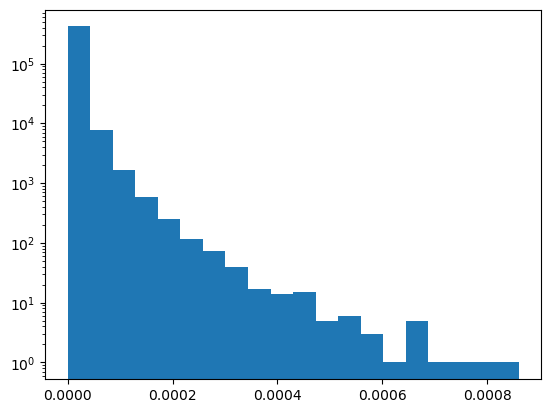

In [70]:
plt.hist(log_test_preds[:, 4], bins=20)
plt.gca().set_yscale("log")

In [75]:
np.exp(log_alphas[:, 1]).argmin()

377592

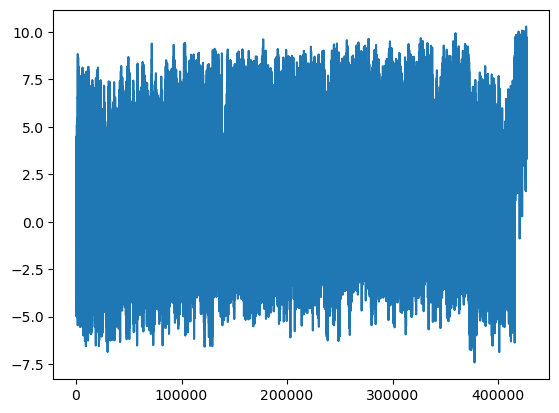

In [80]:
plt.plot(log_alphas[:, 1])

In [64]:
log_alphas.argmin()

755185

In [37]:
np.count_nonzero(log_test_preds[:, 4] > log_test_preds[:, 6])

0

In [27]:
def partial_dependence(data, mod, var_index, var_values):
    pd_data = np.copy(data)
    pd_vals = np.zeros((data.shape[0], mod.output_shape[1], var_values.shape[0]))
    for v, var_val in enumerate(var_values):
        pd_data[:, var_index] = var_val
        pd_vals[:, :, v] = mod.predict(pd_data, batch_size=50000)
    return pd_vals

In [28]:
x_norm_range = np.arange(-5, 5.2, 0.2)
pd_outs = {}
for x, x_col in enumerate(x_cols):
    print(x_col)
    pd_outs[x_col] = partial_dependence(test_x_data, ev_model, x, x_norm_range)

pr_3km
pr_5km
tk_3km
tk_5km
eu_3km
eu_5km
ev_3km
ev_5km
qv_3km
qv_5km
dbz_max


In [29]:
x_norm_range = np.arange(-5, 5.2, 0.2)
pd_outs_base = {}
for x, x_col in enumerate(x_cols):
    print(x_col)
    pd_outs_base[x_col] = partial_dependence(test_x_data, base_model, x, x_norm_range)

pr_3km
pr_5km
tk_3km
tk_5km
eu_3km
eu_5km
ev_3km
ev_5km
qv_3km
qv_5km
dbz_max


In [32]:
pd_outs_base[x_col].shape

(427255, 2, 51)

In [30]:
test_all_data = current_data.loc[test_index]

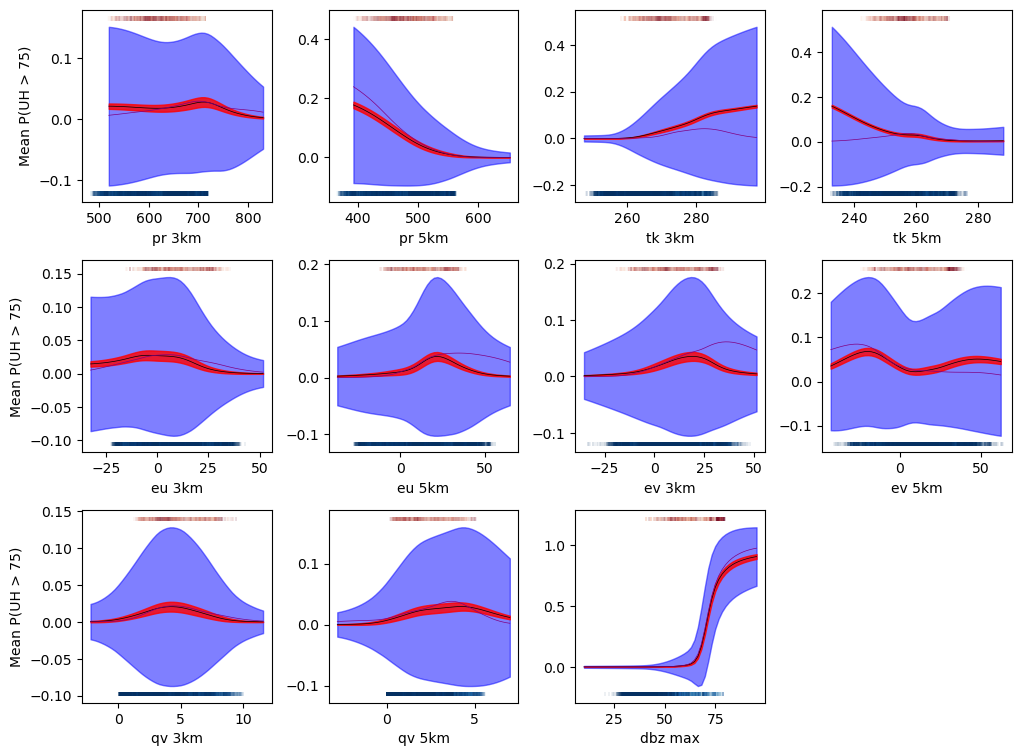

In [33]:
fix, axes = plt.subplots(3, 4, figsize=(12, 9))
plt.subplots_adjust(wspace=0.3, hspace=0.3)
x_vals = x_norm_range
pos = test_all_data["rotation_label"] == 1
neg = test_all_data["rotation_label"] == 0
for a, ax in enumerate(axes.ravel()):
    if a < len(x_cols):
        x_unscaled = x_vals * scaler.scale_[a] + scaler.mean_[a]
        x_bar = np.copy(test_all_data[x_cols[a]].values)
        if x_cols[a][:2] == "qv":
            x_unscaled *= 1000
            x_bar *= 1000
        ax.plot(x_unscaled, pd_outs[x_cols[a]][:,1].mean(axis=0), color='k', lw=0.5)
        ax.plot(x_unscaled, pd_outs_base[x_cols[a]][:,1].mean(axis=0), color='purple', lw=0.5)

        ax.fill_between(x_unscaled, 
                     pd_outs[x_cols[a]][:,1].mean(axis=0) + np.sqrt(pd_outs[x_cols[a]][:,6].mean(axis=0)),
                    pd_outs[x_cols[a]][:,1].mean(axis=0) - np.sqrt(pd_outs[x_cols[a]][:,6].mean(axis=0)), 
                    color='b', alpha=0.5)
        ax.fill_between(x_unscaled, 
                     pd_outs[x_cols[a]][:,1].mean(axis=0) + np.sqrt(pd_outs[x_cols[a]][:,4].mean(axis=0)),
                    pd_outs[x_cols[a]][:,1].mean(axis=0) - np.sqrt(pd_outs[x_cols[a]][:,4].mean(axis=0)), 
                        color='r', alpha=0.8)
        ax.set_xlabel(x_cols[a].replace("_", " "))
        ax.scatter(x_bar[neg], ax.get_ylim()[0] * np.ones(int(neg.sum())), 10, test_all_data.loc[neg, "uh25_max"], 
                   marker='|', linewidths=0.1, cmap="RdBu_r", vmin=0, vmax=150)
        ax.scatter(x_bar[pos], ax.get_ylim()[1] * np.ones(int(pos.sum())), 10, test_all_data.loc[pos, "uh25_max"], 
                   marker='|', linewidths=0.1, cmap="RdBu_r", vmin=0, vmax=150)

        if a % 4 == 0:
            ax.set_ylabel("Mean P(UH > 75)")
    else:
        ax.set_axis_off()
plt.savefig("deepconus_pdp_unc.png", dpi=300, bbox_inches="tight")

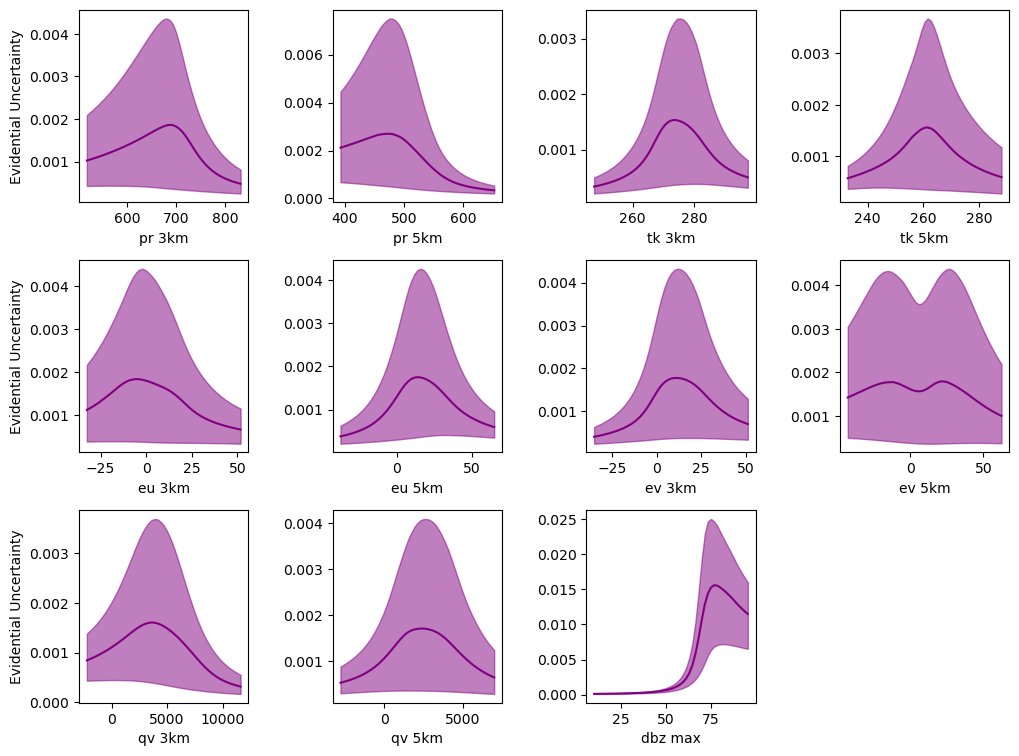

In [34]:
fix, axes = plt.subplots(3, 4, figsize=(12, 9))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
x_vals = x_norm_range
for a, ax in enumerate(axes.ravel()):
    if a < len(x_cols):
        x_unscaled = x_vals * scaler.scale_[a] + scaler.mean_[a]
        x_bar = np.copy(test_all_data[x_cols[a]].values)
        if x_cols[a][:2] == "qv":
            x_unscaled *= 1000
            x_bar *= 1000
        if x_cols[a][:2] == "qv":
            x_unscaled *= 1000
        ax.plot(x_unscaled, pd_outs[x_cols[a]][:,2].mean(axis=0), color='purple')
        ax.fill_between(x_unscaled, np.percentile(pd_outs[x_cols[a]][:,2], 90, axis=0), 
                        np.percentile(pd_outs[x_cols[a]][:,2], 10, axis=0),
                        color='purple', alpha=0.5)

        #ax.plot(x_unscaled, pd_outs[x_cols[a]][:,1].mean(axis=0), color='r')
        #ax.plot(x_unscaled, pd_outs[x_cols[a]][:,0].mean(axis=0), color='b')
        ax.set_xlabel(x_cols[a].replace("_", " "))
        if a % 4 == 0:
            ax.set_ylabel("Evidential Uncertainty")
    else:
        ax.set_axis_off()
plt.savefig("deepconus_pdp_evi_unc.png", dpi=300, bbox_inches="tight")

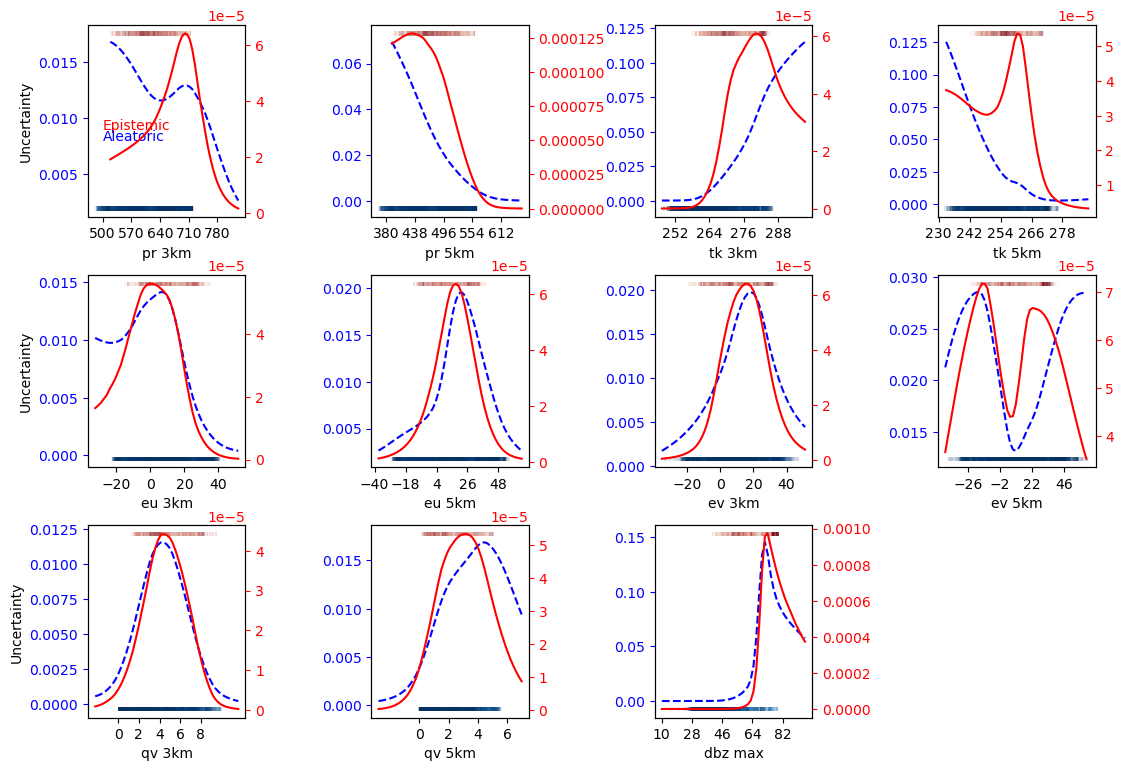

In [35]:
fix, axes = plt.subplots(3, 4, figsize=(13, 9))
plt.subplots_adjust(wspace=0.8, hspace=0.3)
pos = test_all_data["rotation_label"] == 1
neg = test_all_data["rotation_label"] == 0

for a, ax in enumerate(axes.ravel()):
    if a < len(x_cols):
        x_unscaled = x_vals * scaler.scale_[a] + scaler.mean_[a]
        x_bar = np.copy(test_all_data[x_cols[a]].values)
        if x_cols[a][:2] == "qv":
            x_unscaled *= 1000
            x_bar *= 1000
        ax2 = ax.twinx()
        epip = ax2.plot(x_unscaled, pd_outs[x_cols[a]][:,4].mean(axis=0), color='r', label="Epistemic")

        alep = ax.plot(x_unscaled, pd_outs[x_cols[a]][:,6].mean(axis=0), color='blue', linestyle='--', label="Aleatoric") 
        ax.set_xlabel(x_cols[a].replace("_", " "))
        ax.tick_params(axis='y', colors='blue')
        ax2.tick_params(axis='y', colors='red')
        x_lim = np.around(ax.get_xlim(), -1)
        ax.set_xticks(np.arange(x_lim[0], x_lim[1], int((x_lim[1] - x_lim[0]) / 5)))
        if a == 0:
            ax.text(500, 0.009, "Epistemic", color="r")
            ax.text(500, 0.008, "Aleatoric", color="b")
        if a % 4 == 0:
            ax.set_ylabel("Uncertainty")
        ax.scatter(x_bar[neg], ax.get_ylim()[0] * np.ones(int(neg.sum())), 10, test_all_data.loc[neg, "uh25_max"], 
                   marker='|', linewidths=0.1, cmap="RdBu_r", vmin=0, vmax=150)
        ax.scatter(x_bar[pos], ax.get_ylim()[1] * np.ones(int(pos.sum())), 10, test_all_data.loc[pos, "uh25_max"], 
                   marker='|', linewidths=0.1, cmap="RdBu_r", vmin=0, vmax=150)
    else:
        ax.set_axis_off()
plt.savefig("deepconus_pdp_epi_ale_unc.png", dpi=300, bbox_inches="tight")

<AxesSubplot:>

In [127]:
test_all_data

,datetime,center_lat,center_lon,pr_1km,pr_3km,pr_5km,pr_7km,tk_1km,tk_3km,tk_5km,...,qv_7km,dbz_max,dbz_mean,uh25_max,rotation_label,valid_datetime,valid_date,lr_3-5km,ush_1-5km,valid_year
21289,2004-01-02 00:00:00,38.207138,-91.044067,875.974976,686.731873,531.617676,405.451538,283.821228,272.945557,259.113800,...,0.000707,42.913654,12.804272,1.603104,0.0,2004-01-02 00:00:00,2004-01-02,6.915878,6.915878,2004
21290,2004-01-02 00:00:00,38.399380,-89.523224,886.722900,695.351257,538.543640,411.072937,283.234558,273.305542,259.827728,...,0.000786,37.796535,22.827778,0.376333,0.0,2004-01-02 00:00:00,2004-01-02,6.738907,6.738907,2004
21291,2004-01-02 00:00:00,40.303047,-88.419250,877.485657,686.163452,530.164978,403.802155,282.441589,270.056305,257.907166,...,0.000613,40.211315,21.026955,1.067610,0.0,2004-01-02 00:00:00,2004-01-02,6.074570,6.074570,2004
21292,2004-01-02 03:00:00,38.250340,-88.556244,888.964355,696.509766,539.500000,411.799622,283.913757,272.526489,260.340393,...,0.000725,37.944004,27.832232,0.358617,0.0,2004-01-02 03:00:00,2004-01-02,6.093048,6.093048,2004
21293,2004-01-02 03:00:00,38.950726,-86.516357,882.248901,690.151001,534.138916,407.647766,282.704926,271.644653,259.790527,...,0.000742,44.098072,24.551630,0.633126,0.0,2004-01-02 03:00:00,2004-01-02,5.927063,5.927063,2004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387399,2011-12-04 06:00:00,30.182785,-101.561462,837.528076,655.878784,507.374481,387.256958,282.967407,272.138763,259.546997,...,0.000130,62.737400,-1.365668,108.606018,1.0,2011-12-04 06:00:00,2011-12-04,6.295883,6.295883,2011
1387400,2011-12-04 06:00:00,30.274658,-100.936188,835.332397,654.319458,506.474243,386.645874,283.262329,272.460083,260.045258,...,0.000253,62.737400,17.238022,108.606018,1.0,2011-12-04 06:00:00,2011-12-04,6.207413,6.207413,2011
1387401,2011-12-04 06:00:00,30.278122,-100.810425,834.662231,653.810669,506.114563,386.382690,283.286469,272.503723,260.100525,...,0.000263,62.737400,18.577297,108.606018,1.0,2011-12-04 06:00:00,2011-12-04,6.201599,6.201599,2011
1387402,2011-12-04 06:00:00,30.495380,-100.818268,830.919434,650.553589,503.342224,384.026123,282.484711,271.957611,259.528931,...,0.000259,62.737400,18.692692,108.606018,1.0,2011-12-04 06:00:00,2011-12-04,6.214340,6.214340,2011


In [230]:
pd_outs["qv_5km"][:,6].mean(axis=0)

array([0.00171749, 0.00201041, 0.00233972, 0.00271332, 0.00313959,
       0.00361898, 0.00415605, 0.0047451 , 0.0053745 , 0.00604216,
       0.00674614, 0.00744855, 0.0081304 , 0.00877546, 0.00940455,
       0.01001235, 0.01057932, 0.01108248, 0.01153705, 0.01194803,
       0.01234516, 0.01277223, 0.01325566, 0.01381735, 0.01445125,
       0.01515744, 0.01590815, 0.01667779, 0.01745053, 0.01817989,
       0.01882348, 0.01932723, 0.01965957, 0.01980078, 0.01976301,
       0.01954586, 0.01917359, 0.01866586, 0.0180283 , 0.01727965,
       0.01645145])

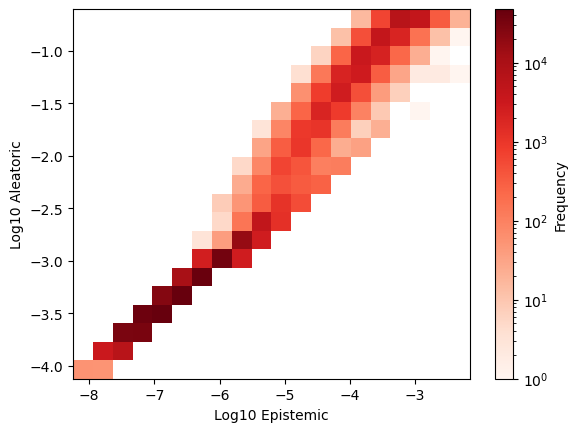

In [41]:
_ = plt.hist2d(np.log10(test_preds[:, 4]), np.log10(test_preds[:, 6]), cmin=1, bins=20, 
               norm=LogNorm(), cmap="Reds")
plt.xlabel("Log10 Epistemic")
plt.ylabel("Log10 Aleatoric")
plt.colorbar(label="Frequency")


In [221]:
case_time = pd.Timestamp("2013-05-20 21:00:00")

In [222]:
test_day = test_all_data.loc[test_all_data["valid_datetime"] == case_time]
test_day_probs = test_preds[test_all_data["valid_datetime"] == case_time]

In [223]:
conus1_path = "/gpfs/fs1/collections/rda/data/ds612.0/CTRLradrefl/REFLC/wrf2d_d01_CTRL_REFLC_10CM_201304-201306.nc"
radar_ds = xr.open_dataset(conus1_path)

In [224]:
conus1_3d_path = "/gpfs/fs1/collections/rda/data/ds612.0/CTRL3D/"
tk_ds = xr.open_dataset(join(conus1_3d_path, "2013", "wrf3d_d01_CTRL_TK_20130520.nc"))
z_ds = xr.open_dataset(join(conus1_3d_path, "2013", "wrf3d_d01_CTRL_Z_20130520.nc"))
wrf_vars = xr.open_dataset("/gpfs/fs1/collections/rda/data/ds612.0/INVARIANT/RALconus4km_wrf_constants.nc")

In [246]:
conus1_2d_path = "/gpfs/fs1/collections/rda/data/ds612.0/CTRL/"
psfc_ds = xr.open_dataset(join(conus1_2d_path, 
                               "2013", "wrf2d_d01_CTRL_PSFC_201304-201306.nc"))
t2_ds = xr.open_dataset(join(conus1_2d_path, 
                               "2013", "wrf2d_d01_CTRL_T2_201304-201306.nc"))
pwat_ds = xr.open_dataset(join(conus1_2d_path, 
                               "2013", "wrf2d_d01_CTRL_PWAT_201304-201306.nc"))
psfc = psfc_ds["PSFC"].sel(Time=case_time)
t2 = t2_ds["T2"].sel(Time=case_time)
pwat = pwat_ds["PWAT"].sel(Time=case_time)
mslp = psfc * np.exp(wrf_vars["HGT"][0] / (287 * t2 / 9.81))

In [239]:
mslp

<xarray.DataArray (south_north: 1015, west_east: 1359)>
array([[101553.75 , 101556.48 , 101554.15 , ..., 101359.06 , 101348.51 ,
        101356.15 ],
       [101554.13 , 101558.01 , 101557.33 , ..., 101348.98 , 101348.516,
        101355.73 ],
       [101551.63 , 101556.69 , 101557.76 , ..., 101343.23 , 101340.05 ,
        101330.7  ],
       ...,
       [103586.27 , 103587.92 , 103580.516, ..., 101728.98 , 101731.91 ,
        101750.03 ],
       [103583.72 , 103588.02 , 103580.8  , ..., 101715.13 , 101715.47 ,
        101712.12 ],
       [103595.664, 103590.11 , 103582.516, ..., 101710.734, 101711.08 ,
        101716.7  ]], dtype=float32)
Coordinates:
    Time     datetime64[ns] 2013-05-20T21:00:00
    XLAT     (south_north, west_east) float32 18.14 18.15 18.15 ... 52.43 52.42
    XLONG    (south_north, west_east) float32 -122.9 -122.8 ... -57.0 -56.95
Dimensions without coordinates: south_north, west_east

In [227]:
zs_valid = z_ds["Z"].sel(Time=case_time)
zs_un = (0.5 * (zs_valid[1:] + zs_valid[:-1])).values

In [228]:
tk_vals = tk_ds["TK"].sel(Time=case_time).values
tks = np.zeros((2, tk_vals.shape[1], tk_vals.shape[2]))
z_i_vals = np.array([3000.0, 5000.0])
for i in range(tks.shape[1]):
    for j in range(tks.shape[2]):
        tks[:, i, j] = np.interp(z_i_vals, zs_un[:, i, j], tk_vals[:, i, j])

In [203]:
lr = (tks[0] - tks[1]) / 2

In [229]:
radar_grid = radar_ds["REFLC_10CM"].sel(Time=case_time)

In [145]:
radar_ds["XLAT"]

<xarray.DataArray 'XLAT' (south_north: 1015, west_east: 1359)>
[1379385 values with dtype=float32]
Coordinates:
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LATITUDE, SOUTH IS NEGATIVE
    units:        degree_north
    stagger:      
    long_name:    Latitude

In [213]:
from metpy.plots import ctables
# READ AND PARSE HERE
cmap = ctables.registry.get_with_steps('NWSReflectivity',5,5)
print(cmap)

(<matplotlib.colors.BoundaryNorm object at 0x2b9713879070>, <matplotlib.colors.ListedColormap object at 0x2b97138798b0>)


/glade/work/dgagne/miniconda3/envs/risk/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


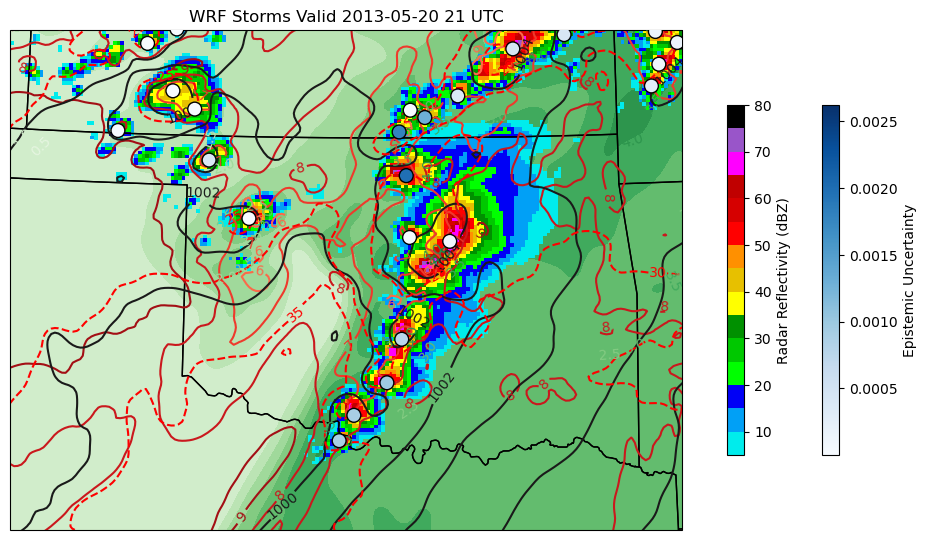

In [266]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.LambertConformal(central_longitude=-97.53348, central_latitude=38.33643, standard_parallels=[32, 46])
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-102, -94, 33, 38], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
pwat_cont = plt.contourf(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(pwat * 100, 2),
             np.arange(0, 6.5, 0.5), cmap="Greens", transform=ccrs.PlateCarree())
plt.clabel(pwat_cont)
radar = plt.pcolormesh(radar_ds["XLONG"], radar_ds["XLAT"], np.ma.array(radar_grid, mask=radar_grid < 5), 
               transform=ccrs.PlateCarree(), cmap=cmap[1], vmin=5, vmax=80)
t_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], gaussian_filter(lr, 1),
             transform=ccrs.PlateCarree(), cmap="Reds")
plt.clabel(t_cont)
p_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(mslp / 100, 2), 
                     np.arange(980, 1022, 2), colors='0.1', transform=ccrs.PlateCarree())
plt.clabel(p_cont)
t2_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(t2 - 273, 2), 
                     np.arange(0, 40, 5), colors='r', linestyles='--', transform=ccrs.PlateCarree())
plt.clabel(t2_cont)

epi_scat = plt.scatter(test_day["center_lon"], test_day["center_lat"], 100, 
            test_day_probs[:, 4], 
            transform=ccrs.PlateCarree(), cmap="Blues", alpha=1, edgecolor='k', zorder=5)
plt.colorbar(epi_scat, label="Epistemic Uncertainty", shrink=0.7, fraction=0.05)
plt.colorbar(radar, label="Radar Reflectivity (dBZ)", shrink=0.7, fraction=0.05)
case_time_str = case_time.strftime("%Y-%m-%d %H UTC")
file_time_str = case_time.strftime("%Y%m%d_%H")
plt.title(f"WRF Storms Valid {case_time_str}")
plt.savefig(f"wrf_storms_epi_{file_time_str}.png", dpi=300, bbox_inches="tight")

/glade/work/dgagne/miniconda3/envs/risk/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


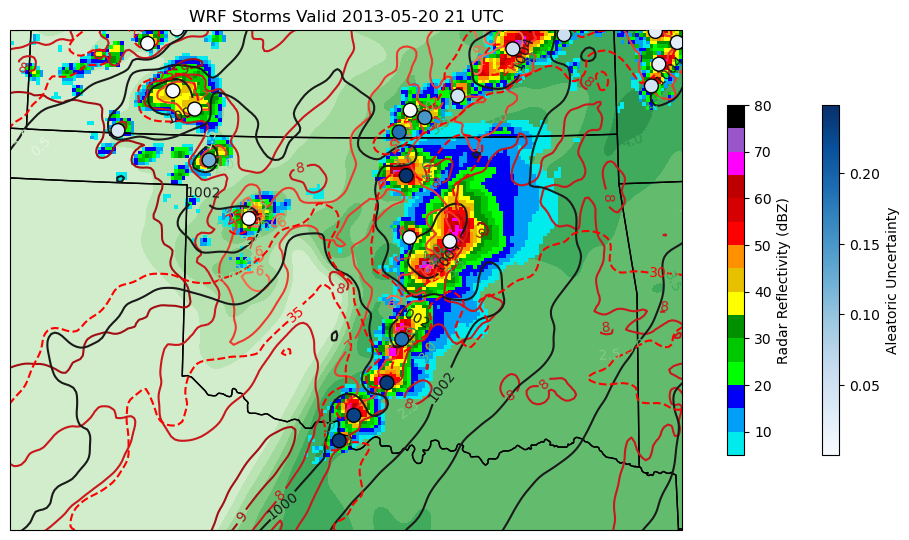

In [267]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.LambertConformal(central_longitude=-97.53348, central_latitude=38.33643, standard_parallels=[32, 46])
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-102, -94, 33, 38], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
pwat_cont = plt.contourf(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(pwat * 100, 2),
             np.arange(0, 6.5, 0.5), cmap="Greens", transform=ccrs.PlateCarree())
plt.clabel(pwat_cont)
radar = plt.pcolormesh(radar_ds["XLONG"], radar_ds["XLAT"], np.ma.array(radar_grid, mask=radar_grid < 5), 
               transform=ccrs.PlateCarree(), cmap=cmap[1], vmin=5, vmax=80)
t_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], gaussian_filter(lr, 1),
             transform=ccrs.PlateCarree(), cmap="Reds")
plt.clabel(t_cont)
p_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(mslp / 100, 2), 
                     np.arange(980, 1022, 2), colors='0.1', transform=ccrs.PlateCarree())
plt.clabel(p_cont)
t2_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(t2 - 273, 2), 
                     np.arange(0, 40, 5), colors='r', linestyles='--', transform=ccrs.PlateCarree())
plt.clabel(t2_cont)

epi_scat = plt.scatter(test_day["center_lon"], test_day["center_lat"], 100, 
            test_day_probs[:, 6], 
            transform=ccrs.PlateCarree(), cmap="Blues", alpha=1, edgecolor='k', zorder=5)
plt.colorbar(epi_scat, label="Aleatoric Uncertainty", shrink=0.7, fraction=0.05)
plt.colorbar(radar, label="Radar Reflectivity (dBZ)", shrink=0.7, fraction=0.05)
case_time_str = case_time.strftime("%Y-%m-%d %H UTC")
file_time_str = case_time.strftime("%Y%m%d_%H")
plt.title(f"WRF Storms Valid {case_time_str}")
plt.savefig(f"wrf_storms_ale_{file_time_str}.png", dpi=300, bbox_inches="tight")

/glade/work/dgagne/miniconda3/envs/risk/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


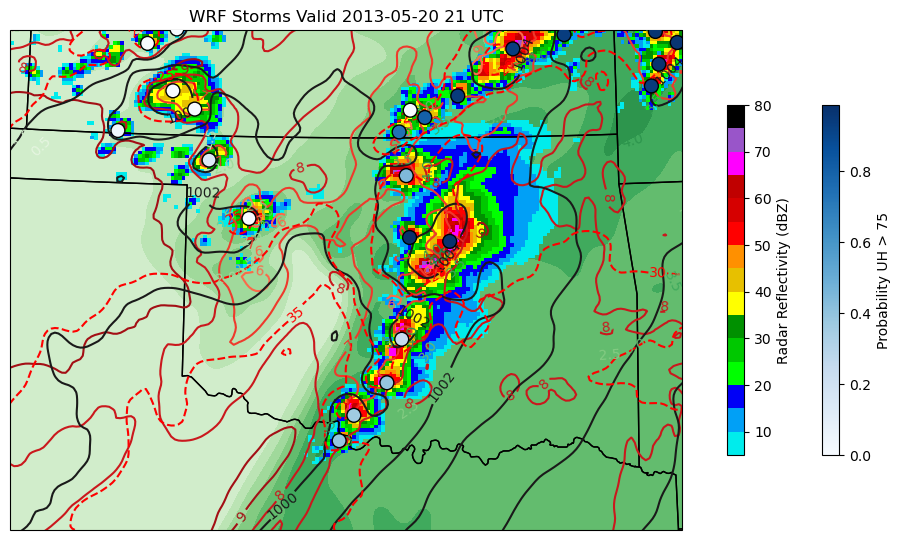

In [268]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.LambertConformal(central_longitude=-97.53348, central_latitude=38.33643, standard_parallels=[32, 46])
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-102, -94, 33, 38], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
pwat_cont = plt.contourf(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(pwat * 100, 2),
             np.arange(0, 6.5, 0.5), cmap="Greens", transform=ccrs.PlateCarree())
plt.clabel(pwat_cont)
radar = plt.pcolormesh(radar_ds["XLONG"], radar_ds["XLAT"], np.ma.array(radar_grid, mask=radar_grid < 5), 
               transform=ccrs.PlateCarree(), cmap=cmap[1], vmin=5, vmax=80)
t_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], gaussian_filter(lr, 1),
             transform=ccrs.PlateCarree(), cmap="Reds")
plt.clabel(t_cont)
p_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(mslp / 100, 2), 
                     np.arange(980, 1022, 2), colors='0.1', transform=ccrs.PlateCarree())
plt.clabel(p_cont)
t2_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(t2 - 273, 2), 
                     np.arange(0, 40, 5), colors='r', linestyles='--', transform=ccrs.PlateCarree())
plt.clabel(t2_cont)

epi_scat = plt.scatter(test_day["center_lon"], test_day["center_lat"], 100, 
            test_day_probs[:, 1], 
            transform=ccrs.PlateCarree(), cmap="Blues", alpha=1, edgecolor='k', zorder=5)
plt.colorbar(epi_scat, label="Probability UH > 75", shrink=0.7, fraction=0.05)
plt.colorbar(radar, label="Radar Reflectivity (dBZ)", shrink=0.7, fraction=0.05)
case_time_str = case_time.strftime("%Y-%m-%d %H UTC")
file_time_str = case_time.strftime("%Y%m%d_%H")
plt.title(f"WRF Storms Valid {case_time_str}")
plt.savefig(f"wrf_storms_prob_{file_time_str}.png", dpi=300, bbox_inches="tight")

In [378]:
day_ex = tf.constant(test_x_case)
with tf.GradientTape() as g:
    g.watch(day_ex)
    pred_out = ev_model(day_ex)
    grads = g.gradient(pred_out[:, 4], day_ex).numpy()

/glade/work/dgagne/miniconda3/envs/risk/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


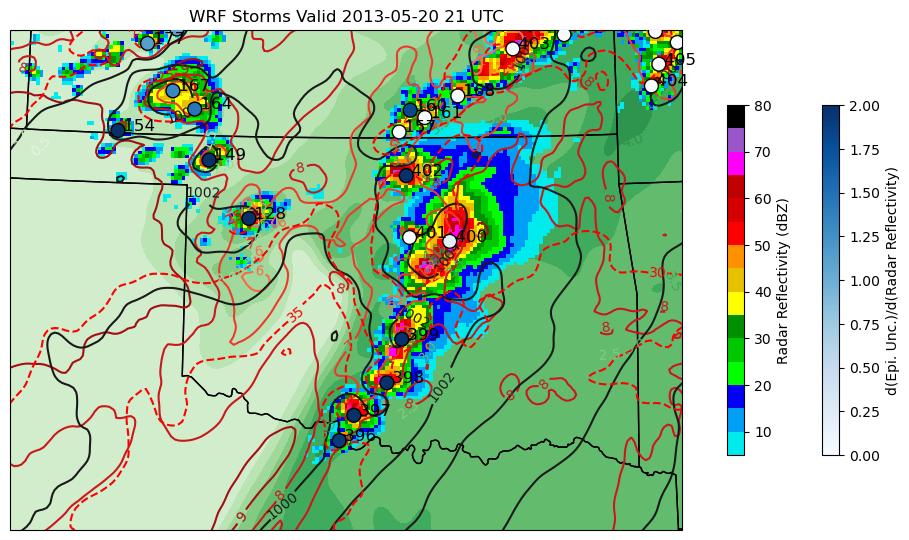

In [406]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.LambertConformal(central_longitude=-97.53348, central_latitude=38.33643, standard_parallels=[32, 46])
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-102, -94, 33, 38], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
pwat_cont = plt.contourf(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(pwat * 100, 2),
             np.arange(0, 6.5, 0.5), cmap="Greens", transform=ccrs.PlateCarree())
plt.clabel(pwat_cont)
radar = plt.pcolormesh(radar_ds["XLONG"], radar_ds["XLAT"], np.ma.array(radar_grid, mask=radar_grid < 5), 
               transform=ccrs.PlateCarree(), cmap=cmap[1], vmin=5, vmax=80)
t_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], gaussian_filter(lr, 1),
             transform=ccrs.PlateCarree(), cmap="Reds")
plt.clabel(t_cont)
p_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(mslp / 100, 2), 
                     np.arange(980, 1022, 2), colors='0.1', transform=ccrs.PlateCarree())
plt.clabel(p_cont)
t2_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], 
                     gaussian_filter(t2 - 273, 2), 
                     np.arange(0, 40, 5), colors='r', linestyles='--', transform=ccrs.PlateCarree())
plt.clabel(t2_cont)

epi_scat = plt.scatter(test_day["center_lon"], test_day["center_lat"], 100, 
            grads[:, -1] / test_day_probs[:, 4], 
            transform=ccrs.PlateCarree(), cmap="Blues", vmin=0, vmax=2, alpha=1, edgecolor='k', zorder=5)
plt.colorbar(epi_scat, label="d(Epi. Unc.)/d(Radar Reflectivity)", shrink=0.7, fraction=0.05)
plt.colorbar(radar, label="Radar Reflectivity (dBZ)", shrink=0.7, fraction=0.05)
for o, i in enumerate(test_day.index):
    c_lon = test_day.loc[i, "center_lon"]
    c_lat = test_day.loc[i, "center_lat"]
    if (-102 < c_lon < -94) and (33 < c_lat < 38): 
        plt.text(c_lon, c_lat, f" {o:d}",
            transform=ccrs.PlateCarree(), zorder=7, fontsize=12)
case_time_str = case_time.strftime("%Y-%m-%d %H UTC")
file_time_str = case_time.strftime("%Y%m%d_%H")
plt.title(f"WRF Storms Valid {case_time_str}")
plt.savefig(f"wrf_storms_refl_grad_{file_time_str}.png", dpi=300, bbox_inches="tight")

In [387]:
test_day.loc[1199780, "center_lat"]

25.316849

In [259]:
pwat.values.max() * 100

6.933651119470596

In [383]:
(grads / test_day_probs[:, 4])

112

In [289]:
test_x_case = test_x_data[test_all_data["valid_datetime"] == case_time]

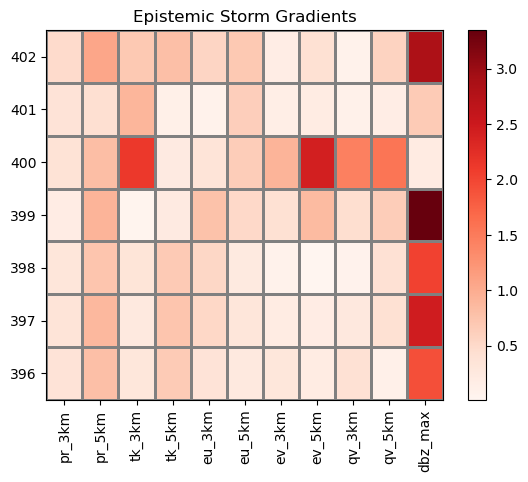

In [409]:
plt.pcolormesh(np.abs(grads[396:403]) / test_day_probs[396:403, 4].reshape(-1, 1),
               cmap="Reds", edgecolor='0.5')
plt.xticks(np.arange(11) + 0.5, x_cols, rotation=90)
plt.yticks(np.arange(7) + 0.5, np.arange(396, 403), rotation=0)
plt.title("Epistemic Storm Gradients")
plt.colorbar()
plt.savefig("epi_storm_grads.png", dpi=300, bbox_inches="tight")

In [327]:
np.where(test_day["uh25_max"] > 75)

(array([393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405,
        406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417]),)

In [ ]:
test_

([<matplotlib.axis.XTick at 0x2b98ab366250>,
 [Text(0, 0, 'pr_3km'),
  Text(1, 0, 'pr_5km'),
  Text(2, 0, 'tk_3km'),
  Text(3, 0, 'tk_5km'),
  Text(4, 0, 'eu_3km'),
  Text(5, 0, 'eu_5km'),
  Text(6, 0, 'ev_3km'),
  Text(7, 0, 'ev_5km'),
  Text(8, 0, 'qv_3km'),
  Text(9, 0, 'qv_5km'),
  Text(10, 0, 'dbz_max')])

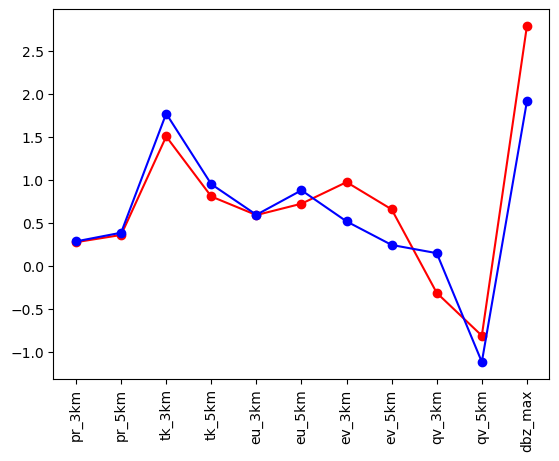

In [414]:
#plt.plot(test_x_case[393], 'ko-')
plt.plot(test_x_case[400], 'ro-')
plt.plot(test_x_case[396], 'bo-')
plt.xticks(np.arange(11), x_cols, rotation=90)


In [336]:
test_day_probs[393, 4] * .1

7.351855165325106e-05

In [280]:
grads.numpy()

array([[-1.5798276e-08, -2.2512930e-08,  2.7575561e-08, ...,
        -7.0537740e-09,  8.6622238e-09,  5.2310380e-08],
       [-8.8224033e-09, -1.1938781e-08,  1.6451908e-08, ...,
        -2.7141878e-09,  4.2378101e-09,  2.8489605e-08],
       [-1.3973361e-08, -1.8352228e-08,  2.8179192e-08, ...,
        -9.0873655e-09,  7.8409714e-09,  5.1101573e-08],
       ...,
       [ 9.8198056e-05, -8.3847903e-05, -4.3451996e-04, ...,
         4.4483738e-04,  6.7334360e-04,  1.5150735e-03],
       [ 4.7008591e-05, -1.4739436e-04, -3.3944951e-05, ...,
         3.9512562e-04,  5.9080654e-04,  1.7412251e-03],
       [ 4.6618989e-05, -2.2586554e-04, -4.7559885e-04, ...,
         2.3166439e-04,  4.0705144e-04,  1.3745337e-03]], dtype=float32)

In [274]:
grads.numpy()

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.0613642 ,  0.01245927, -0.21294673, ...,  0.21526761,
         0.26216057,  0.51010966],
       [ 0.04057209,  0.00462297,  0.00076729, ...,  0.19034043,
         0.18831852,  0.54191965],
       [ 0.04740006, -0.01624828, -0.19320935, ...,  0.15300886,
         0.11922968,  0.35503942]], dtype=float32)

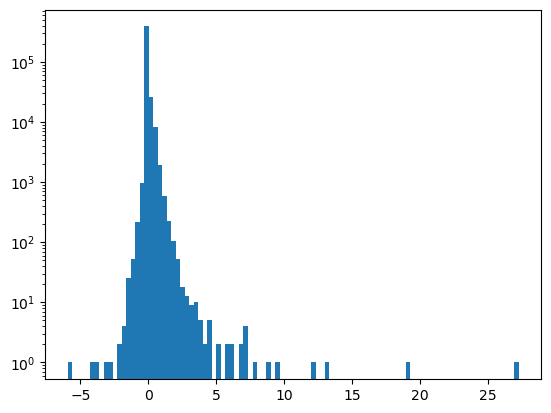

In [270]:
plt.hist(grads.numpy()[:, ], bins=100)
plt.gca().set_yscale("log")

In [155]:
test_day_grads = grads.numpy()[test_all_data["valid_datetime"] == pd.Timestamp("2013-05-20 21:00:00")]

/glade/work/dgagne/miniconda3/envs/risk/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1797: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = matplotlib.axes.Axes.pcolormesh(self, *args, **kwargs)


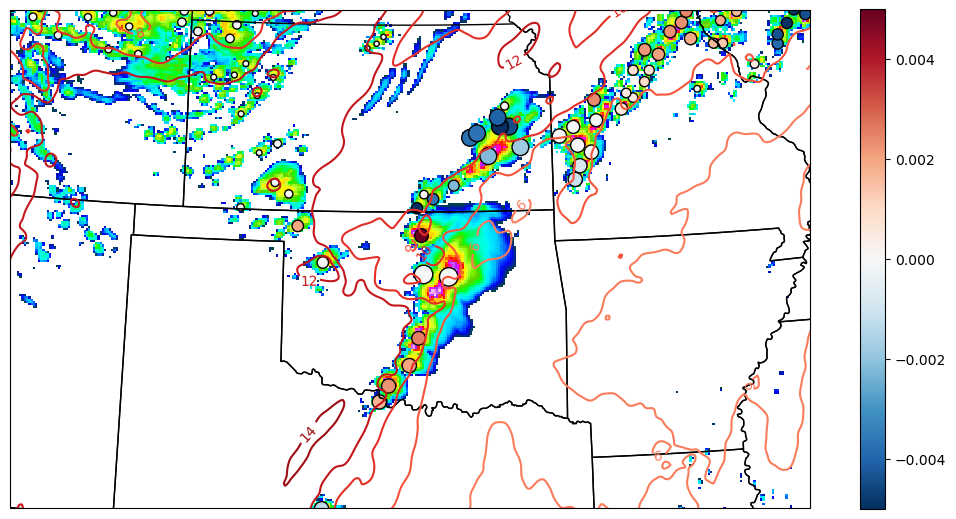

In [157]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.LambertConformal(central_longitude=-97.53348, central_latitude=38.33643, standard_parallels=[32, 46])
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-105, -90, 32, 40], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.pcolormesh(radar_ds["XLONG"], radar_ds["XLAT"], np.ma.array(radar_grid, mask=radar_grid < 5), 
               transform=ccrs.PlateCarree(), cmap="gist_ncar", vmin=0, vmax=75)
t_cont = plt.contour(tk_ds["XLONG"], tk_ds["XLAT"], gaussian_filter(lr_grid, 2),
             transform=ccrs.PlateCarree(), cmap="Reds")
plt.clabel(t_cont)
plt.scatter(test_day["center_lon"], test_day["center_lat"], np.sqrt(test_day["uh25_max"]) * 10, 
            test_day_grads[:, -1], 
            transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=-0.005, vmax=0.005, alpha=1, edgecolor='k')
plt.colorbar()

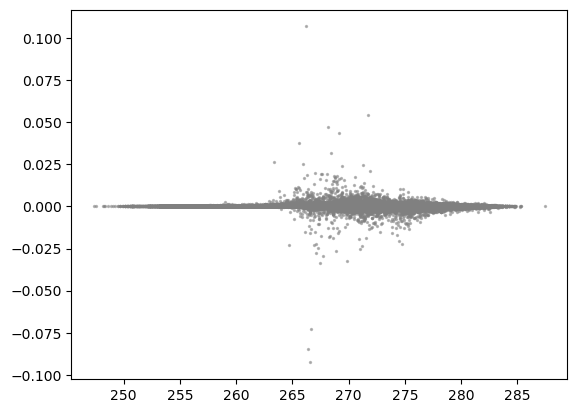

In [153]:
plt.scatter(test_all_data["tk_3km"], grads.numpy()[:, 2], 2, alpha=0.5, color='0.5')

In [150]:
x_cols

['pr_3km',
 'pr_5km',
 'tk_3km',
 'tk_5km',
 'eu_3km',
 'eu_5km',
 'ev_3km',
 'ev_5km',
 'qv_3km',
 'qv_5km',
 'dbz_max']

In [89]:
tk_ds["TK"].sel(Time=pd.Timestamp("2013-05-20 21:00:00"))[0]

<xarray.DataArray 'TK' (south_north: 1015, west_east: 1359)>
[1379385 values with dtype=float32]
Coordinates:
    Time     datetime64[ns] 2013-05-20T21:00:00
    XLAT     (south_north, west_east) float32 18.14 18.15 18.15 ... 52.43 52.42
    XLONG    (south_north, west_east) float32 -122.9 -122.8 ... -57.0 -56.95
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    stagger:      
    description:  Air temperature
    units:        K
    long_name:    TK

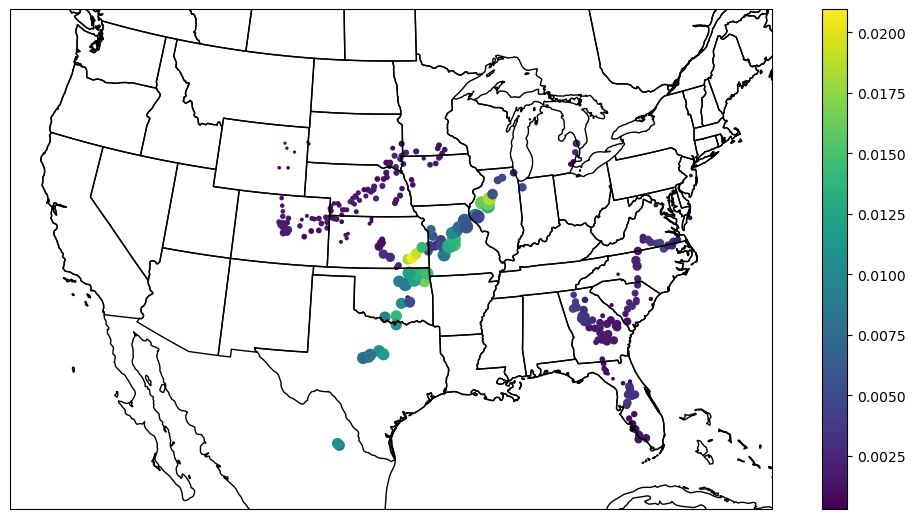

In [258]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.LambertConformal(central_longitude=-97.53348, central_latitude=38.33643, standard_parallels=[32, 46])
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-120.81, -74, 23.15, 50], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.scatter(test_day["center_lon"], test_day["center_lat"], np.sqrt(test_day["uh25_max"]) * 5, test_day_probs[:, 2], 
            transform=ccrs.PlateCarree())
plt.colorbar()

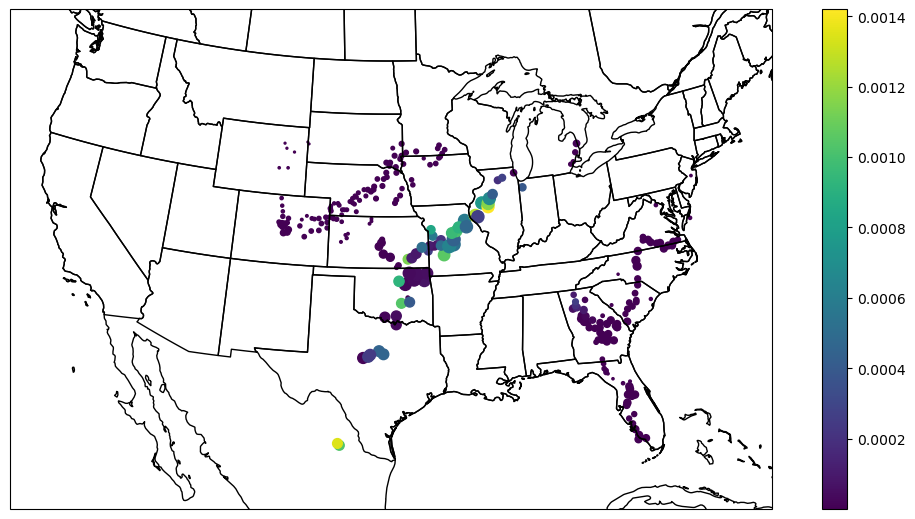

In [259]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.LambertConformal(central_longitude=-97.53348, central_latitude=38.33643, standard_parallels=[32, 46])
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-120.81, -74, 23.15, 50], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.scatter(test_day["center_lon"], test_day["center_lat"], np.sqrt(test_day["uh25_max"]) * 5, test_day_probs[:, 4], 
            transform=ccrs.PlateCarree())
plt.colorbar()

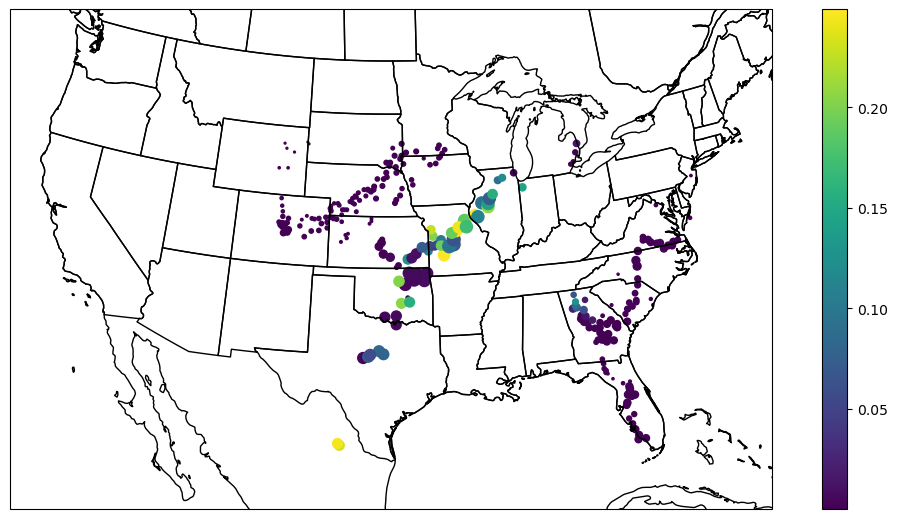

In [260]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.LambertConformal(central_longitude=-97.53348, central_latitude=38.33643, standard_parallels=[32, 46])
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-120.81, -74, 23.15, 50], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
plt.scatter(test_day["center_lon"], test_day["center_lat"], np.sqrt(test_day["uh25_max"]) * 5, test_day_probs[:, 6], 
            transform=ccrs.PlateCarree())
plt.colorbar()

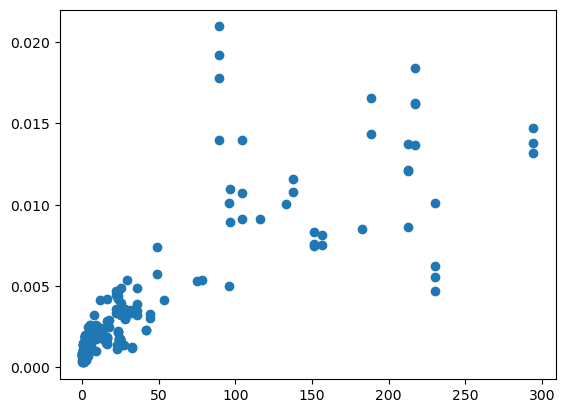

In [81]:
plt.scatter(test_day["uh25_max"], test_day_probs[:, 2])

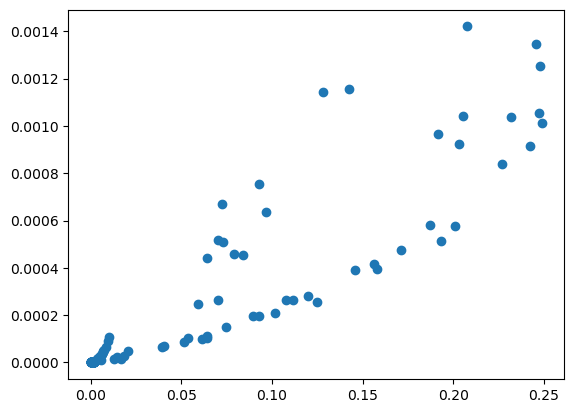

In [98]:
plt.scatter(test_day_probs[:,5], test_day_probs[:, 3])

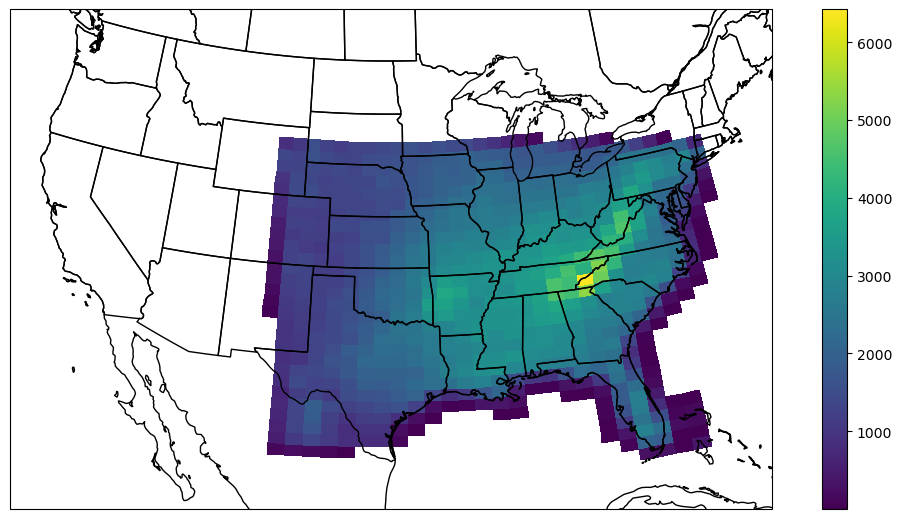

In [309]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.LambertConformal(central_longitude=-97.53348, central_latitude=38.33643, standard_parallels=[32, 46])
ax = fig.add_axes([0, 0, 1, 1], projection=proj)
ax.set_extent([-120.81, -74, 23.15, 50], ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
h_vals, h_lon, h_lat = np.histogram2d(current_data["center_lon"], current_data["center_lat"], 30)
pc = ax.pcolormesh(h_lon, h_lat, np.ma.array(h_vals.T, mask=h_vals.T < 1), transform=ccrs.PlateCarree())
plt.colorbar(pc)